In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/contractions/contractions.csv


# 1. Import dependencies

In [2]:
# Main
import pandas as pd
import numpy as np
import re
import pickle
from collections import Counter

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For naive bayes
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# 1. Importing the dataset
https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7

**Context**

In this project, the "sentiment140" dataset will be used. It contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can therefore be used to detect sentiment. The training data was automatically created, as opposed to having humans manual annotate tweets. In the approach, it was assumed that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. They used the Twitter Search API to collect these tweets by using keyword search. 

**Content**

It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet ( 2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY
5. user: the user that tweeted (robotickilldozr)
6. text: the text of the tweet (Lyx is cool)

A link to kaggle regarding the dataset with resources about how it was generated is available [here](https://www.kaggle.com/kazanova/sentiment140).

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

## 1.1 Load dataframe
First make sure you have downloaded the dataset from [here](https://www.kaggle.com/kazanova/sentiment140) and put the csv file in the "input" folder. If you are running it on kaggle make sure the data is in the kaggle input folder.

In [3]:
# Reading the dataset with no columns titles and with latin encoding 
df_raw = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["sentiment", "time", "date", "query", "username", "tweet"]

# Show the first 10 rows of the dataframe.
df_raw.head()

,sentiment,time,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 1.2 Drop uneccessary columns 

In [4]:
# Ommiting every column except for the text and the label, as we won't need any of the other information
df = df_raw[['sentiment', 'tweet']]

# Replacing the label 4 with 1.
df['sentiment'] = df['sentiment'].replace(4,1)

df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


## 1.3 Check balance

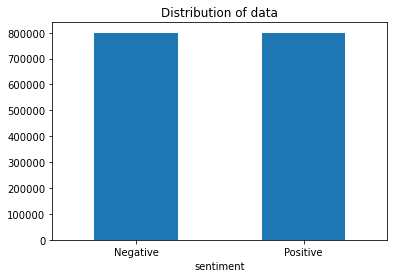

In [5]:
# Checking the data's output balance
# Label '4' denotes positive sentiment and '0' denotes negative sentiment
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

## 1.4 Trim size of dataframe (optional)
During development it can be handy to work with just a fraction of the whole dataset. Choose if you want to trim dataset by setting trim_df below. 



No trimming done


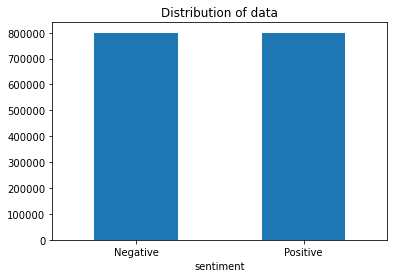

In [6]:
trim_df = False # If you set this to true -> trim dataframe to 1/80 for efficiency 

is_trimmed = False # This should always be initialized to false. Will be set to true if trimming occurs 

if trim_df:
    print("Trimming the dataset to 1/80")
    print("Nr rows before trim:", len(df))
    df_pos = df[df['sentiment'] == 1]
    df_neg = df[df['sentiment'] == 0] 
    df_pos = df_pos.iloc[:int(len(df_pos)/80)]
    df_neg = df_neg.iloc[:int(len(df_neg)/80)]
    df = pd.concat([df_pos, df_neg])
    trim_df = False # prevent running more than once  
    is_trimmed = True
    print("Nr rows after trim:", len(df))
else:
    print("No trimming done")
    
# Checking the data's output balance
# Label '4' denotes positive sentiment and '0' denotes negative sentiment
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

# 2. Cleaning and pre-processing the data

## 2.1 Inspect data 
First take a look at some tweets in the df shown below. As you can see, there exists a lot of user names, digits and punctutaions, hyperlinks etc that we can clean up before any tokenizing or lemmatizing. 

In [7]:
df.head(10)

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


## 2.3 Preprocessing all tweets
Now let's define a function that applies all the preprocessing steps mentioned above

**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that deep learning algorithms can perform better.

Tweets usually contains a lot of information apart from the text, like mentions, hashtags, urls, emojis or symbols. Since normally, NLP models cannot parse those data, we need to clean up the tweet and replace tokens that actually contains meaningful information for the model.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **'http' or 'https' or 'www'** are replaced by **'<url\>'**.
3. **Replacing Usernames:** Replace @Usernames with word **'<user\>'**. [eg: '@Kaggle' to '<user\>'].
4. **Replacing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. [eg: 'Heyyyy' to 'Heyy']
5. **Replacing Emojis:** Replace emojis by using a regex expression. [eg: ':)' to '<smile\>']
6. **Replacing Contractions:** Replacing contractions with their meanings. [eg: "can't" to 'can not']
7. **Removing Non-Alphabets:** Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.

As much as the preprocessing steps are important, the actual sequence is also important while cleaning up the text. For example, removing the punctuations before replacing the urls means the regex expression cannot find the urls. Same with mentions or hashtags. So make sure, the actual sequence of cleaning makes sense.

In [8]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('../input/contractions/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

Cleaning up the tweet text and storing it in **"processed_tweet"** field in the dataframe.

In [9]:
%%time
df['processed_tweet'] = df.tweet.apply(preprocess_apply)

CPU times: user 2min 30s, sys: 284 ms, total: 2min 30s
Wall time: 2min 31s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# 3. Analyze the data

## 3.1 Inspect some data

In [10]:
df.head(10)

,sentiment,tweet,processed_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",<user> <url> aww thatis a bummer you shou...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,<user> i dived many times for the ball manage...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",<user> no it is not behaving at all i am mad...
5,0,@Kwesidei not the whole crew,<user> not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,<user> hey long time no see yes rains a bi...
8,0,@Tatiana_K nope they didn't have it,<user> nope they did not have it
9,0,@twittera que me muera ?,<user> que me muera


## 3.2 Analyze most common words

In [11]:
processedtext = list(df['processed_tweet'])
if is_trimmed: 
    data_pos = processedtext[10000:]
    data_neg = processedtext[:10000]
else: 
    data_pos = processedtext[800000:]
    data_neg = processedtext[:800000]

## 3.3 Word cloud of most common positive words

Word clouds are a beautiful way of visualizing words frequencies in text documents.
It produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes and less frequent words with smaller font sizes.

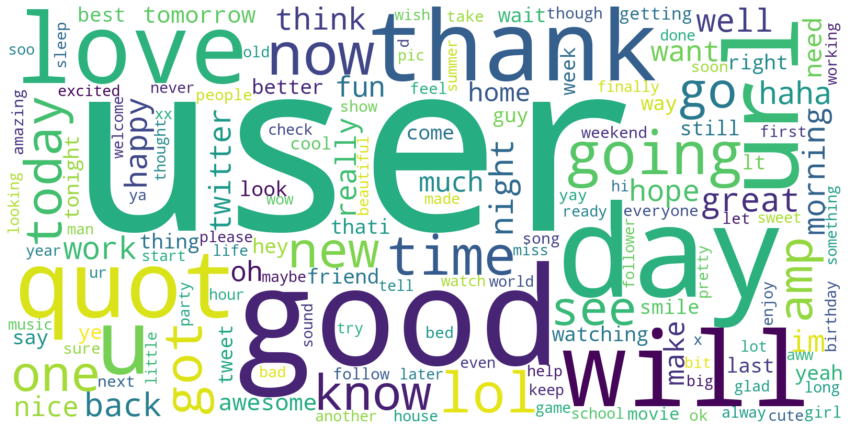

In [12]:
plt.figure(figsize = (15,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,  background_color ='white', min_font_size = 25,
               collocations=False).generate(" ".join(data_pos))      
plt.axis("off") 

plt.imshow(wc , interpolation = 'bilinear')

## 3.4 Word cloud of most common negative words

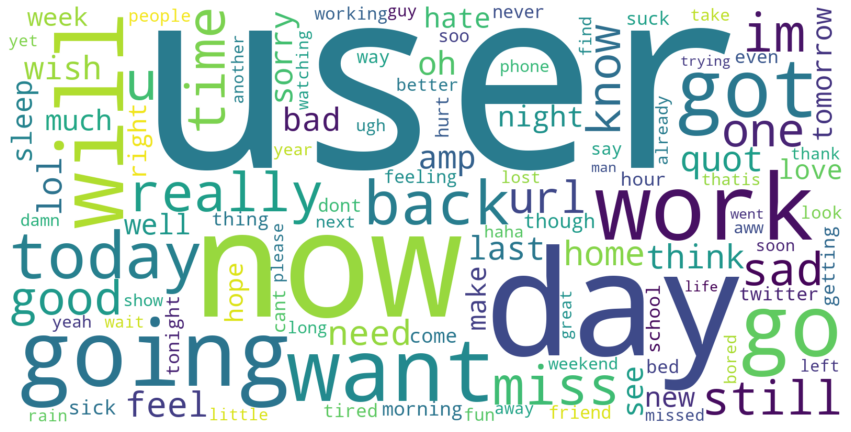

In [13]:
plt.figure(figsize = (15,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,  background_color ='white', min_font_size = 25,
               collocations=False).generate(" ".join(data_neg))            
plt.axis("off") 
plt.imshow(wc , interpolation = 'bilinear')

## 3.5 Comments
It seems like the preproccessing is quite good! Some words were left on purpose, for example usernames were replaced by $<user>$. This will help the LSTM model to understand the context in a sentence. The positive words feel like they have a strong motivatoin behind them, while some of the negative words are not as intuative. However, there is some overlop between positive and negative words, eg. "work", "get", "go" and "day" are very common in both classes. 

# 4. Split the data into train & test

The preprocessed data is divided into 2 sets of data:
    
 - Training Data: The sample of data used to fit the model. Contains 90% of dataset.
 - Test Data:  The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset. Contains 10% of dataset.

In [14]:
from sklearn.model_selection import train_test_split

#X_data, y_data = np.array(df['processed_tweet']), np.array(df['sentiment'])

df_train, df_test = train_test_split(df, test_size=0.10, random_state=42)
X_train, y_train = np.array(df_train['processed_tweet']), np.array(df_train['sentiment'])
X_test, y_test = np.array(df_test['processed_tweet']), np.array(df_test['sentiment'])

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 0.05, random_state = 42)

print("Nr of samples in each set after split:\n")
print("  TRAIN size:", len(X_train))
print("  TEST size:", len(X_test), "\n")

print('Data Split done.')

pos = 0
neg = 0
for val in y_train: 
    if val == 0:
        neg +=1 
    else: pos +=1
print("pos", pos, "neg", neg)

Nr of samples in each set after split:

  TRAIN size: 1440000
  TEST size: 160000 

Data Split done.
pos 719812 neg 720188


## 4.2 Comments
The small unbalance between positive and negative tweets in the training data is insignificant.

# 7. Naive Bayes

Now that our data is somewhat clean, we can use it to build our classification model. One of the most commonly used classification models in Natural Language Processing (NLP) is the Naive Bayesian.
Naive Bayesian classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but rather a family of algorithms where all of them make the following naive assumptions:

- All features are independent from each other.
- Every feature contributes equally to the output.

In our case, these two assumptions can be interpreted as:

- Each word is independent from the other words, no relation between any two words of a given sentence.
- Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its relative position in the sentence.

Example: "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting", in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', albeit them having a stronger meaning and a different meaning respectively in first and second sentences.


The Bayes' Theorem describes the probability of an event $A$, based on prior knowledge of conditions $B$ that might be related to the event: 

$P(A | B) = \frac{P(B | A)P(A)}{P(B)}$

In our case, this can be intuitively interpreted as the probability of a tweet being positive, based on prior knowledge of the words inside the input text. In a nutshell, this probability is: the probability of the first word occuring in a positive tweet, times, the probability of the second word occuring in a positive tweet, ..., times, the probability of a tweet being positive. 




In [15]:
from time import time
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
                
start_time = time()

pipe = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB())])


# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'vect__binary': [True, False], # If True, all non zero counts are set to 1. This is what how interpreted "set of words"
    'vect__ngram_range': [(1,1), (1,2)], # unigram, unigram + bigram
    'clf__alpha': [1, 0.1]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1) # defaults to 5-fold 
search.fit(df_train['processed_tweet'], df_train['sentiment']) # Pipeline requires pd 

print("Training complete in", time() - start_time, "seconds")
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training complete in 1851.1056060791016 seconds
Best parameter (CV score=0.805):
{'clf__alpha': 1, 'vect__binary': True, 'vect__ngram_range': (1, 2)}


As we can see above, we got a CV score of 0.0.805 using parameters:
- alpha = 1
- vect__binary = True -> set-of-of words
- vect_ngram_range = (1,2) -> unigram + bigram

### Clasification report

In [16]:
from sklearn.metrics import classification_report

y_pred_mnb = search.predict(df_test['processed_tweet'])
print(classification_report(df_test['sentiment'], y_pred_mnb,))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81     79812
           1       0.82      0.79      0.80     80188

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000



81% accuracy is quite nice. And without the 5-fold cross validation it only takes about 30 seconds to train the model, which is impressive. Let's try the model out with some custom tweets.  

### Confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

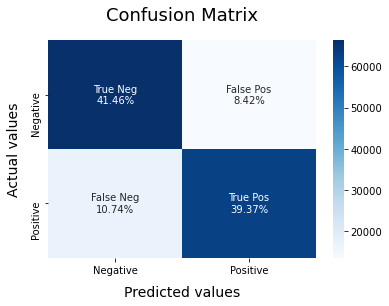

In [18]:
# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred_mnb, df_test['sentiment'])

### Predicting on custom tweets

Let's test the model on some custom tweets

In [19]:
def label_to_str(label):
    if label == 0: return "Negative :"
    return "Positive :"

def nb_predict(df_custom_tweets):
    df_custom_tweets['tweet_processed'] = df_custom_tweets.tweet.apply(preprocess_apply)
    sentiments = search.predict(df_custom_tweets['tweet_processed'])
    for index, row in enumerate(df_custom_tweets['tweet']):
        print(label_to_str(sentiments[index]), row)
   

In [20]:

tweet1 = "Lunch at McDonalds today was not tasty"
tweet2 = "I am finally done with my homwork, feeling great" 
tweet3 = "Could have been better"

tweet4 = "The song was good!"
tweet5 = "The song was not good!"
tweet6 = "This song was great!"
tweet7 = "This song wasn't great!"

tweet8 = "That's just what I needed today.."
tweet9 = "I love being ignored" 
tweet10 = "Just broke my phone, awesome day thus far!"

tweet_list = [tweet1, tweet2, tweet3, tweet4, tweet5, tweet6, tweet7, tweet8, tweet9, tweet10]
custom_tweets = pd.DataFrame({'tweet': tweet_list})

nb_predict(custom_tweets)


Negative : Lunch at McDonalds today was not tasty
Positive : I am finally done with my homwork, feeling great
Negative : Could have been better
Positive : The song was good!
Negative : The song was not good!
Positive : This song was great!
Positive : This song wasn't great!
Positive : That's just what I needed today..
Negative : I love being ignored
Negative : Just broke my phone, awesome day thus far!


As the model only evaluates sentences word by word, independently, it performs  poorly when it comes to negations and other multi-words constructs. For example, the input:

- The song was good!

The model will simply take each individual word (after preprocessing) and calculate each word's probability to be either positive and negative, and then finally multiply everything together. Therefore it is expected that the model will perform poorly on examples such:

- The concert was not good! 

And as we can see in the output above both of these examples came out as positive. 

The model will encounter similar problems in sarcastic and ironic sentences, as we can see in the example:

- That's just what I needed today..

Other than that, the model seems quite nice! But it is worth mentioning that a naive bayes model perhaps does not generalize well.

The model will perform good on data similar to what the model was trained on. For example, if the model learned that I love music and I love dancing carry a positive sentiment, it would be pretty easy for it to classify I love studying as a sentence carrying a positive sentiment. However, if the model were to classify I adore engineers, it would most probably miss-classify it. As it never encountered any of these words before, therefore it is unable to properly classify it, and would output a random choice.

# 5. LSTM 

In order to feed our text data to our LSTM model, we'll have to go through several extra preprocessing steps.

Most neural networks expect numbers as inputs. Thus, we'll have to convert our text data to numerical data.

## 5.1 Creating Word Embeddings using Word2Vec model

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, word embeddings are vector representations of a particular word.

Word2Vec was developed by Google and is one of the most popular technique to learn word embeddings using shallow neural network. Word2Vec can create word embeddings using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW).

In [21]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

Word2Vec() function creates and trains the word embeddings using the data passed.

**Training Parameters**:

- size: The number of dimensions (N) that the Word2Vec maps the words onto. Bigger size values require more training data, but can lead to better (more accurate) models.
- workers: Specifies the number of worker threads for training parallelization, to speed up training.
- min_count: min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them.

In [22]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

word2vec_model.wv.save('Word2Vec-twitter-100-dims')
print("Finished training word2vec")
print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Finished training word2vec
Vocabulary Length: 50464
CPU times: user 5min 22s, sys: 2.12 s, total: 5min 24s
Wall time: 3min 18s


## 5.2 Analyse some words in word space

In [23]:
word2vec_model.most_similar("lol")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('haha', 0.8358275294303894),
 ('lmao', 0.8318643569946289),
 ('hahaha', 0.7398496270179749),
 ('jk', 0.661290168762207),
 ('lmfao', 0.653235912322998),
 ('hehe', 0.646796703338623),
 ('lmaoo', 0.6353700160980225),
 ('hahah', 0.6336390376091003),
 ('nah', 0.6253114342689514),
 ('hahahaha', 0.6215089559555054)]

In [24]:
word2vec_model.most_similar("like")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('weird', 0.5903339982032776),
 ('liek', 0.5651185512542725),
 ('appetizing', 0.5502831935882568),
 ('lik', 0.5321270227432251),
 ('stalkerish', 0.5288711190223694),
 ('promising', 0.5093318819999695),
 ('wierd', 0.5071029663085938),
 ('familiar', 0.5034307837486267),
 ('appealing', 0.4990258812904358),
 ('retarded', 0.4960208833217621)]

In [25]:
word2vec_model.most_similar("stress")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('frustration', 0.6445218920707703),
 ('energy', 0.5914714932441711),
 ('guilt', 0.5816131830215454),
 ('nausea', 0.5801706910133362),
 ('illness', 0.5731566548347473),
 ('strength', 0.5673167109489441),
 ('pressure', 0.5638859868049622),
 ('boredom', 0.5622326135635376),
 ('caffeine', 0.5579589605331421),
 ('sickness', 0.5353475213050842)]

## 5.2 Tokenizing and Padding datasets
Tokenization is a common task in Natural Language Processing (NLP). It’s a fundamental step in both traditional NLP methods like Count Vectorizer and Advanced Deep Learning-based architectures like Transformers.

Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. We need to have the inputs with the same size, this is where the padding is necessary.

Padding is the process by which we can add padding tokens at the start or end of a sentence to increase it's length upto the required size. If required, we can also drop some words to reduce to the specified length.

- Tokenizer: Tokenizes the dataset into a list of tokens.
- pad_sequences: Pads the tokenized data to a certain length.
- The input_length has been set to 60. This will be the length after the data is tokenized and padded.

In [26]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Defining the Tokenizer and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the delimiter space ' '.

Args in Tokenizer():

- filters: Characters to filter out from the sentences to tokenize.
- lower: True/False. Whether to lowerCase the sentence or not.
- oov_token: Out of Vocabulary token to put in for words which aren't in the tokenizer vocab.
- Filters and lower has been turned off because we've already done those steps during the preprocessing step.

In [27]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(df['processed_tweet'])

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 272836


Tokenizing the X_train and X_test dataset and padding them to the length 'input_length'.

The tokenized list is pre-padded, i.e padding tokens are added to the start. After padding, the length of the data would be equal to 'input_length'.

In [28]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1440000, 60)
X_test.shape : (160000, 60)


## 5.3 Creating Embedding Matrix
Embedding Matrix is a maxtrix of all words and their corresponding embeddings. We use embedding matrix in an Embedding layer in our model to embedded a token into it's vector representation, that contains information regarding that token or word.

We get the embedding vocabulary from the tokenizer and the corresponding vectors from the Embedding Model, which in this case is the Word2Vec model.

Shape of Embedding matrix is usually the Vocab Length * Embedding Dimension.

In [29]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (272836, 100)


## 5.4 Designing the Model
We are going to build a deeplearning Sequence model. Sequence model are very good at getting the context of a sentence, since it can understand the meaning rather than employ techniques like counting positive or negative words like in a Bag-of-Words model.

In [30]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding


### Model Architecture
1) Embedding Layer: Layer responsible for converting the tokens into their vector representation that is generated by Word2Vec model. We're using the predefined layer from Tensorflow in out model.

Arguments:

- input_dim: Size of the vocabulary.
- output_dim: Dimension of the dense embedding.
- weights: Initiazises the embedding matrix.
- trainable: Specifies whether the layer is trainable or not.

2) Bidirectional: Bidirectional wrapper for RNNs. It means the context are carried from both left to right and right to left in the wrapped RNN layer.

3) LSTM: Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

Arguments:

- units: Positive integer, dimensionality of the output space.
- dropout: Fraction of the units to drop for the linear transformation of the inputs.
- return_sequence: Whether to return the last output in the output sequence, or the full sequence.

4) Conv1D: This layer creates a convolution kernel that is convolved with the layer input over a single dimension to produce a tensor of outputs.

Arguments:

- filters: The dimensionality of the output space (i.e. the number of output filters in the convolution).
- kernel_size: Specifies the length of the 1D convolution window.
- activation: Specifies the activation function to use.

5) GlobalMaxPool1D: Downsamples the input representation by taking the maximum value over the different dimensions.

6) Dense: Dense layer adds a fully connected layer in the model. The argument passed specifies the number of nodes in that layer.

The last dense layer has the activation "Sigmoid", which is used to transform the input to a number between 0 and 1. Sigmoid activations are generally used when we have 2 categories to output in.

In [31]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

## 5.5 Initialize the model



The Model must be compiled to define the loss, metrics and optimizer. Defining the proper loss and metric is essential while training the model.

- Loss: We're using Binary Crossentropy. It is used when we have binary output categories. Check out this article on losses.

- Metric: We've selected Accuracy as it is one of the common evaluation metrics in classification problems when the category data is equal. Learn more about metrics here.

- Optimizer: We're using Adam, optimization algorithm for Gradient Descent. You can learn more about Adam here.

In [32]:
# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
training_model = getModel()
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           27283600  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

## 5.6 Training the Model (or load weigths to skip training)

We now have 2 options, either train the model from scratch (except our embeddding layer which consists of our word2vec layer), or load the weights from a previous training run which I have already run. 

In [33]:
skip_training = False

### Check if we can load weights from prev training

In [34]:
checkpoint_path = '../input/lstm-weights/variables'
checkpoint_dir = os.path.dirname(checkpoint_path)
!ls {checkpoint_dir}

ls: cannot access '../input/lstm-weights': No such file or directory


In [35]:
found_prev_weights = False

if skip_training: 
    # store weights before loading pre-trained weights
    preloaded_layers = training_model.layers.copy()
    preloaded_weights = []
    for pre in preloaded_layers:
        preloaded_weights.append(pre.get_weights())

    # load pre-trained weights
    try: 
        training_model.load_weights(checkpoint_path)

        print("Loading weights from prev training\n")

        # compare previews weights vs loaded weights
        for layer, pre in zip(training_model.layers, preloaded_weights):
            weights = layer.get_weights()

            if weights:
                if np.array_equal(weights, pre):
                    print('not loaded', layer.name)
                else:
                    print('loaded', layer.name)
                    found_prev_weights = True

    except:
        found_prev_weights = False
        print("No previous training done")
else:
    print("No prev weights will be used")


No prev weights will be used


### Model Callbacks¶

Callbacks are objects that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

We can use callbacks to write TensorBoard logs after every batch of training, periodically save our model, stop training early or even to get a view on internal states and statistics during training.

ReduceLROnPlateau: Reduces Learning Rate whenever the gain in performance metric specified stops improving.

- monitor: quantity to be monitored.
- patience: number of epochs with no improvement after which learning rate will be reduced.
- cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.

EarlyStopping: Stop training when a monitored metric has stopped improving.

- monitor: Quantity to be monitored.
- min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
- patience: Number of epochs with no improvement after which training will be stopped.

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
     EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Training the model
We'll now train our model using the fit method and store the output learning parameters in history, which can be used to plot out the learning curve.

Arguements:

- batch_size: Number of samples per gradient update. Increasing the batch_size speeds up the training.
- epochs: Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.
- validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch
- callbacks: List of callbacks to apply during training process.
- verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [37]:
if not found_prev_weights: 
    print("Training from scratch")
    history = training_model.fit(
    X_train, y_train,
    batch_size=1000,
    epochs=15,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1)
else:
    print("Weights already loaded, no training will occur")

Training from scratch
Epoch 1/15
1296/1296 [==============================] - 110s 85ms/step - loss: 0.4337 - accuracy: 0.7968 - val_loss: 0.3919 - val_accuracy: 0.8229
Epoch 2/15
1296/1296 [==============================] - 108s 83ms/step - loss: 0.3977 - accuracy: 0.8179 - val_loss: 0.3801 - val_accuracy: 0.8299
Epoch 3/15
1296/1296 [==============================] - 108s 84ms/step - loss: 0.3860 - accuracy: 0.8246 - val_loss: 0.3718 - val_accuracy: 0.8346
Epoch 4/15
1296/1296 [==============================] - 108s 83ms/step - loss: 0.3784 - accuracy: 0.8290 - val_loss: 0.3662 - val_accuracy: 0.8367
Epoch 5/15
1296/1296 [==============================] - 109s 84ms/step - loss: 0.3727 - accuracy: 0.8318 - val_loss: 0.3648 - val_accuracy: 0.8377
Epoch 6/15
1296/1296 [==============================] - 108s 83ms/step - loss: 0.3687 - accuracy: 0.8342 - val_loss: 0.3616 - val_accuracy: 0.8389
Epoch 7/15
1296/1296 [==============================] - 108s 83ms/step - loss: 0.3649 - accuracy

## 5.7 Evaluating the Model

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative Predictions**. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Learning curve

Learning curves show the relationship between training set size and your chosen evaluation metric (e.g. RMSE, accuracy, etc.) on your training and validation sets. They can be an extremely useful tool when diagnosing your model performance, as they can tell you whether your model is suffering from bias or variance.

**This section requires that training was run in this notebook**

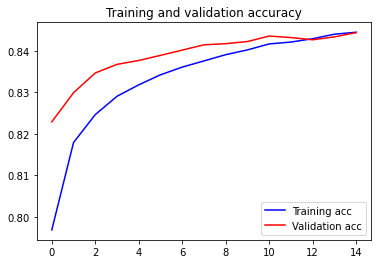

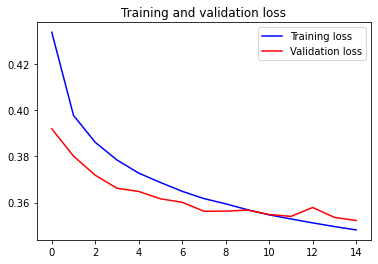

In [38]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the training curve we can conclude that our model doesn't have bias nor is it overfitting. As such, the **regularization** introduced in the model seem to work perfectly well. For example we have have two drop out layers embeded in the LSTM layers of the model. The accuracy curve has flattened but is still rising, which means that training for more epochs probably will yield even better results.

The **validation loss** is lower than the **training loss** because the dropouts in LSTM aren't active while evaluating the model.

**Over-Fitting** is basically the phenomenon where the model's performance on validation data starts degrading, while still achieving great progress on the test set. In other words, the model is doing exceptionally well on learning specific examples it has been trained on, but is failing to generalize to data it never saw in its training phase.

**Dropout** is one of the many regularization techniques, and also one of the simplest to implement and most commonly used. Basically, what dropout does is that it randomly eliminates several (based on a parametrized percentage rate) neurons connections in the network, rendering the model less complex, and forcing the model to only look at part of a given example. The random elimination of connections in the model is repeated randomly for each example training data.


For example, let's consider the following sentences, with a dropout layer with a rate of 0.5 (50% of connections will be eliminated): 

> "Another kind of regularization can be directly applied to the cost function"
>
> "This is my first ever notebook. Hope you're enjoying it so far!"

The output of the dropout layer could look like the following:

> "kind of regularization be to function"
>
> "This my notebook. you enjoying it far!"

Thus, the model will only have information on a part of the input example, and should be able to escape over-fitting particular characteristics of the training data.

### Confusion Matrix

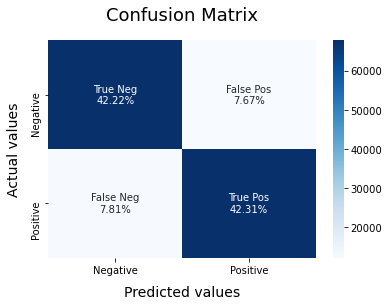

In [39]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

From the confusion matrix, it can be concluded that the model makes more False Negative predictions than positive. This means that the model is somewhat biased towards predicting negative sentiment.

### Classification Report

In [40]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     79812
           1       0.85      0.84      0.85     80188

    accuracy                           0.85    160000
   macro avg       0.85      0.85      0.85    160000
weighted avg       0.85      0.85      0.85    160000



Using the classification report, we can see that that the model achieves more than **84% Accuracy** after training just **15 epochs.** This is really good and better than most other models trained on the sentiment140 dataset achieve.

### Predicting on custom tweets
Now let’s have some fun testing our new and all-powerful model on some custom data!

This model will return values between 0 and 1, representing it’s confidence on whether a tweet holds a negative or a positive sentiment. The closer the value is to 0, the more confident the model is that this tweet is negative. The closer the value is to 1, the more confident the model is that this tweet is negative.

In [41]:
def lstm_predict(df_custom_tweets):
    df_custom_tweets.head()
    X_custom = np.array(df_custom_tweets['tweet_processed'])
    X_custom = pad_sequences(tokenizer.texts_to_sequences(X_custom), maxlen=input_length)
    y_pred = training_model.predict(X_custom)
    pred = np.where(y_pred>=0.5, 1, 0)
    for index, row in enumerate(df_custom_tweets['tweet']):
        print(y_pred[index][0], "=", label_to_str(pred[index]), row)

In [42]:
lstm_predict(custom_tweets)

0.017332245 = Negative : Lunch at McDonalds today was not tasty
0.9966364 = Positive : I am finally done with my homwork, feeling great
0.114176005 = Negative : Could have been better
0.9921577 = Positive : The song was good!
0.0047946824 = Negative : The song was not good!
0.9889665 = Positive : This song was great!
0.008688356 = Negative : This song wasn't great!
0.7773124 = Positive : That's just what I needed today..
0.5147944 = Positive : I love being ignored
0.14499274 = Negative : Just broke my phone, awesome day thus far!


We notice that the LSTM model can in fact understand the relationship between words. For example, it managed to identify that adding a not before a "good",  completely changes its meaning from positive to negative! And it is very confindent in it's decision, reflected by the numbers. 


### Inspecting wrongly predicted data
Let's take a look at some of the wrongly classified data from the model.

In [43]:
correct = 0
                
for i in range(len(X_test)):
    
    if(y_pred[i] != y_test[i]):
        print('Expected', label_to_str(y_test[i]), "\nInput:", df_test['tweet'].iloc[i], "\nProcessed input: ", df_test["processed_tweet"].iloc[i], "\n")
        correct += 1
        
    if correct > 30:
        break

Expected Positive : 
Input: @PerezHilton Zach makes me pee sitting down! And I'm a grown gay man!  
Processed input:  <user> zach makes me pee sitting down  and i am a grown gay man   

Expected Positive : 
Input: @LilPecan Oh, that's really great  Here we have a small blizzard and also cold wind blows... 
Processed input:  <user> oh  thatis really great  here we have a small blizzard and also cold wind blows   

Expected Positive : 
Input: i'm feeling quite sleepy today, wish i could stay in bed today...but OK! is my LAST YEAR, so let's go to school  
Processed input:  i am feeling quite sleepy today  wish i could stay in bed today  but ok  is my last year  so let us go to school  

Expected Positive : 
Input: im turning 18 one week from now  but i don't feel excited  i really don't know why i've seen my friends  they got excited  but on my part 
Processed input:  im turning 18 one week from now  but i do not feel excited  i really do not know why i have seen my friends  they got exci

Skimming through the above missclassified output, we get some insight into why the model won't properly classify several tweets. Some examples seem wrongly labeled in the first place, meaning that the emojis used as labels may noy always reflect the sentiment of the tweet. Many tweets seem to be ironic or sarcastic, and perhaps emojis often are used in the same manner. Ie, people use a happy emoji in combination with a negative tweet.

However, some other tweets are simply hard to classify without further context, and perhaps should have been labeled neutral or been removed from the dataset to start with. 

So all in all, I would say that the current model is relatively robust in classifying the sentiment in a given sentence. 

### Saving the model

We're saving the **tokenizer, Word2Vec and Tensorflow model** for use later.

In [44]:
# Saving Word2Vec-Model
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-dim')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Twitter-Sentiment-LSTM')